In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colors
from matplotlib import cm
from matplotlib.ticker import NullFormatter
from mpl_toolkits.mplot3d import Axes3D

from scipy import stats
from scipy.stats import multivariate_normal

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from skimage.transform import resize

import math

import seaborn as sns; sns.set()
np.random.seed(42)

In [2]:
class genere_distributions():
    nx, ny = 300, 300
    npts = 200
    
    def __init__(self, mu, sigma, angle, prob_C, x_min, x_max, y_min, y_max):
        self.mu = mu
        self.sigma = sigma
        self.angle = angle
        self.prob_C = prob_C
        self.x_min = x_min 
        self.x_max = x_max 
        self.y_min = y_min 
        self.y_max = y_max         
        
        # Calcul du nombre de points 2D dans chacun des nuages de points.
        self.n = (self.npts*self.prob_C).astype(int)
        
        self.n_amas = self.n.shape[0] 
        
        # Génère les données 2D à partir des matrices de covariance individuelles
        # On va se servir de ces ensembles de points pour comparer les zones d'influences de chaque nuage en utilisant 
        # trois méthodes de classifications: 
        #    I:   Linear Discriminant Analysis (Matrice de covariance S partagée)
        #    II:  Quadratic Discriminant Analysis (Matrice de covariance S partagée)
        #    III: Quadratic Discriminant Analysis (Matrices de covariance S individuelles)
        self.genere_dataset()
        
        # Estime les paramètres des PDF gaussiennes à partir de ces données
        self.estime_parametres_dataset()


            
    # Génère les nuages de points 2D à partir des matrices de covariance individuelles
    def genere_dataset(self):
        np.random.seed(42)
        
        # Calcule les différentes matrices de covariance
        self.calcule_cov_mat()
        
        X0 = np.random.multivariate_normal(self.mu[0,:], self.cov[:,:,0], self.n[0])
        y0 = np.zeros(self.n[0])
        for i in range(1, self.n_amas):
            X = np.random.multivariate_normal(self.mu[i,:], self.cov[:,:,i], self.n[i])
            X0 = np.r_[X0, X]
            y0 = np.hstack((y0, np.ones(self.n[i])*i))  
            
        self.X = X0       
        self.y = y0   
        
        
        
    # Calcule les différentes matrices de covariance
    def calcule_cov_mat(self):
        self.cov = np.zeros((2, 2, self.n_amas))
        for i in range(self.n_amas):
            # Matrice de rotation
            theta = np.radians(self.angle[i])
            c, s = np.cos(theta), np.sin(theta)
            R = np.array(((c, -s), (s, c)))        

            # Matrice de covariance avant rotation
            C = np.array([[self.sigma[i, 0]**2, 0.],[0., self.sigma[i, 1]**2]])

            # Matrice de covariance après rotation
            # new_cov = rotation_matrix @ cov @ rotation_matrix.T
            self.cov[:,:,i] = R.dot( C.dot(R.T) )  

            
        
    # Estimation des paramètres des gaussiennes à partir des nuages de points. 
    def estime_parametres_dataset(self):        
        self.mu_hat = np.zeros([self.n_amas,2])
        self.cov_hat = np.zeros([2,2,self.n_amas])
        self.prob_C_hat  = np.zeros([self.n_amas,])

        for i in range(self.n_amas):
            indx = np.where(self.y==i)
            x = np.squeeze(self.X[indx,:])
            self.mu_hat[i,:] = np.mean(x,axis=0)
            self.cov_hat[:,:,i] = np.cov(x.T)
            self.prob_C_hat[i] = self.prob_C[i]
       
        
        
    # Affiche, pour chaque nuage de points, sa distribution de probabilité (PDF), ses contours et sa zone d'influence
    def affiche_PDF_avec_zones_influence(self, texte, texte_pos, affiche_tickmarks=True, nom_figure=None):

        cmap = colors.LinearSegmentedColormap(
            'red_blue_classes',
            {'red': [(0, 1, 1), (1, 0.5, 0.5)],
             'green': [(0, 0.5, 0.5), (1, 0.7, 0.7)],
             'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
        plt.cm.register_cmap(cmap=cmap)
        couleurs = ['red', 'blue', 'black']
        
        # Calcul des positions (x,y) d'un maillage régulier couvrant le plan xy
        self.genere_grid()
        
        fig, ax = plt.subplots(1,3,figsize=(15,5), facecolor='white')

        # Affiche les PDF avec courbes d'équiprobabilité
        for i in range(self.n_amas):        
            # Courbes de contours 
            rv = multivariate_normal(self.mu[i,:], self.cov[:,:,i])
            for j in range(3):
                ax[j].contour(self.xx, self.yy, rv.pdf(self.pos), levels=5, colors=couleurs[i])

                # Position des centroides des distributions
                ax[j].plot(self.mu[i][0], self.mu[i][1],'*', color='yellow', markersize=15, markeredgecolor='grey')
 

        # Courbes délimitant la zone d'influence de chaque nuage de points
        # Méthode I: Linear Discriminant Analysis (Matrice S partagée)
        discriminant = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)     
        self.plot_dataset(discriminant, ax[0])
        ax[0].set_xlim(self.x_min, self.x_max)
        ax[0].set_ylim(self.y_min, self.y_max)
        if (affiche_tickmarks==False):
            # Enlève tickmarks
            ax[0].xaxis.set_major_formatter(NullFormatter())
            ax[0].yaxis.set_major_formatter(NullFormatter())
            
        for i in range(self.n_amas):
            ax[0].text(texte_pos[i][0], texte_pos[i][1], texte[i], horizontalalignment='left', verticalalignment='center', fontsize=14, color='white')

        ax[0].set_xlabel('$x_{1}$',fontsize=18)
        ax[0].set_ylabel('$x_{2}$',rotation=0,fontsize=18)
        ax[0].xaxis.set_label_coords(0.5, -0.08)
        ax[0].yaxis.set_label_coords(-0.08, 0.5)        
        ax[0].set_title("Discriminant lin. (S partagée)",fontsize=16)


        # Méthode II: Quadratic Discriminant Analysis (Matrice S partagée)
        discriminant = QuadraticDiscriminantAnalysis(store_covariance=True)
        self.plot_dataset(discriminant, ax[1])
        ax[1].set_xlim(self.x_min, self.x_max)
        ax[1].set_ylim(self.y_min, self.y_max)
        if (affiche_tickmarks==False):
            # Enlève tickmarks
            ax[1].xaxis.set_major_formatter(NullFormatter())
            ax[1].yaxis.set_major_formatter(NullFormatter())
            
        ax[1].set_xlabel('$x_{1}$',fontsize=18)
        ax[1].set_ylabel('$x_{2}$',rotation=0,fontsize=18)
        ax[1].xaxis.set_label_coords(0.5, -0.08)
        ax[1].yaxis.set_label_coords(-0.08, 0.5)
        ax[1].set_title("Discriminant quad. (S partagée)",fontsize=16)


        
        # Méthode III: Avec fonctions discriminantes indépendantes  (Matrices S indépendantes)
        discriminant = 'QuadraticDiscriminantAnalysis_S_independent'
        self.plot_dataset(discriminant, ax[2])
        ax[2].set_xlim(self.x_min, self.x_max)
        ax[2].set_ylim(self.y_min, self.y_max)
        if (affiche_tickmarks==False):
            # Enlève tickmarks
            ax[2].xaxis.set_major_formatter(NullFormatter())
            ax[2].yaxis.set_major_formatter(NullFormatter())
            
        ax[2].set_xlabel('$x_{1}$',fontsize=18)
        ax[2].set_ylabel('$x_{2}$',rotation=0,fontsize=18)
        ax[2].xaxis.set_label_coords(0.5, -0.08)
        ax[2].yaxis.set_label_coords(-0.08, 0.5)
        ax[2].set_title("Discriminant quad. (S indépendantes)",fontsize=16)

        
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)

        # Sauvegarde de l'image 
        if nom_figure!=None:
            plt.savefig(nom_figure, format="svg")

        plt.show()
        

    def plot_dataset(self, discriminant, ax):
        
        Xgrid = np.c_[self.xx.ravel(), self.yy.ravel()]
        
        if (discriminant=='QuadraticDiscriminantAnalysis_S_independent'):
            # Prédit la classe de chaque point dans les nuages
            self.y_pred = self.QuadraticDiscriminantAnalysis_S_independent(self.X)
            # Identifie la zone d'influence de chaque classe.
            Z = self.QuadraticDiscriminantAnalysis_S_independent(Xgrid)
        else:
            self.y_pred = discriminant.fit(self.X, self.y).predict(self.X) 
            Z = discriminant.predict(Xgrid)  

        Z = Z.reshape(self.xx.shape)

        
        # Affiche les données bien et mal classifiées ainsi que la frontière délimitant la zone 
        # d'influence de chaque nuage de points.
        tp = (self.y == self.y_pred)  # True Positive

        if (self.n_amas==2):           
            tp0, tp1 = tp[self.y == 0], tp[self.y == 1]
            X0, X1 = self.X[self.y == 0], self.X[self.y == 1]
            X0_tp, X0_fp = X0[tp0], X0[~tp0]
            X1_tp, X1_fp = X1[tp1], X1[~tp1]

            # classe 0 en rouge (données bien classifiées '.', mal classifiées 'x')
            ax.scatter(X0_tp[:, 0], X0_tp[:, 1], marker='.', color='red')
            ax.scatter(X0_fp[:, 0], X0_fp[:, 1], marker='x', s=20, color='#990000')

            # classe 1 en bleu (idem)
            ax.scatter(X1_tp[:, 0], X1_tp[:, 1], marker='.', color='blue')
            ax.scatter(X1_fp[:, 0], X1_fp[:, 1], marker='x', s=20, color='#000099')     
        
            ax.pcolormesh(self.xx, self.yy, Z, cmap='red_blue_classes',
                    norm=colors.Normalize(0., 1.), zorder=0) 

            # Affiche la frontière délimitant la zone d'influence de chaque nuage de points
            ax.contour(self.xx, self.yy, Z, [0.5], linewidths=2., colors='white')               
        else:
            
            tp0, tp1, tp2 = tp[self.y == 0], tp[self.y == 1], tp[self.y == 2]
            X0, X1, X2 = self.X[self.y == 0], self.X[self.y == 1], self.X[self.y == 2]
            X0_tp, X0_fp = X0[tp0], X0[~tp0]
            X1_tp, X1_fp = X1[tp1], X1[~tp1]
            X2_tp, X2_fp = X2[tp2], X2[~tp2]

            # classe 0 en rouge (bien classifiées '.', mal classifiées 'x')
            ax.scatter(X0_tp[:, 0], X0_tp[:, 1], marker='.', color='red')
            ax.scatter(X0_fp[:, 0], X0_fp[:, 1], marker='x',
                        s=20, color='#990000')  # dark red

            # classe 1 en bleu (idem)
            ax.scatter(X1_tp[:, 0], X1_tp[:, 1], marker='.', color='blue')
            ax.scatter(X1_fp[:, 0], X1_fp[:, 1], marker='x',
                        s=20, color='#000099')  # dark blue

            # classe 2 en noir (idem)
            ax.scatter(X2_tp[:, 0], X2_tp[:, 1], marker='.', color='black')
            ax.scatter(X2_fp[:, 0], X2_fp[:, 1], marker='x',
                        s=20, color='#000000')  # black

            ax.pcolormesh(self.xx, self.yy, Z, cmap='red_blue_classes',
                    norm=colors.Normalize(0., 2.), zorder=0) 

            # Affiche la frontière délimitant la zone d'influence de chaque nuage de points
            ax.contour(self.xx, self.yy, Z, [0.5, 1.5], linewidths=2., colors='white')    

            
            
    # Calcul des positions (x,y) d'un maillage régulier couvrant le plan xy
    def genere_grid(self):        
        self.xx, self.yy = np.meshgrid(np.linspace(self.x_min, self.x_max, self.nx), 
                                       np.linspace(self.y_min, self.y_max, self.ny))
        self.pos = np.dstack((self.xx, self.yy))

     
    
    # Fonction générant la fonction discriminante de chaque classe puis les applique afin d'identifier la zone
    # d'influence de chaque classe. 
    def QuadraticDiscriminantAnalysis_S_independent(self, X):        
        X = X.T
        
        # Calcul des fonctions discriminantes 
        h = np.zeros((X.shape[1],self.n_amas))
        for i in range(self.n_amas):
            h[:,i] = self.fonction_discriminante(self.mu_hat[i,:], self.cov_hat[:,:,i], self.prob_C_hat[i], X)        

        # Identifie la zone d'influence de chaque nuage de points en prédisant la classe pour chaque 
        # position (x,y) dans le maillage 2D. La classe gagnante est celle pour laquelle h(x) est MINIMALE!
        y_pred = np.argmin(h,axis=1)  
        
        return y_pred
    
    

    # Calcul d'une fonction discriminante
    def fonction_discriminante(self, moy, S, pC, X):
        moy = np.reshape(moy.T, [2,1])
        
        S_inv = np.linalg.inv(S)
        det_S = np.linalg.det(S)
               
        w0 = -0.5*math.log(det_S) + math.log(pC)
        
        ww = np.zeros([X.shape[1]])
        for i in range(X.shape[1]):
            dX = np.reshape(X[:,i], [2,1]) - moy
            ww[i] = (dX.T).dot(S_inv.dot(dX))
        
        h = ww + w0
        
        return h    
    
       


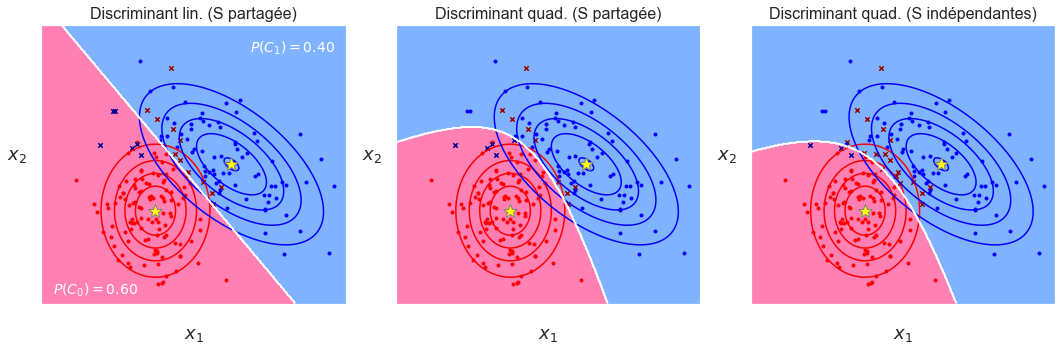

In [3]:
if __name__=='__main__':

    # ------- Paramètres des gaussiennes --------
        
    mu = np.zeros((2,2))
    mu[0,:] = [-1., -1.]
    mu[1,:] = [1., 0.]

    sigma = np.zeros((2,2))
    sigma[0,:] = [.8, .8]
    sigma[1,:] = [1.5, .7]

    angle = np.array([0., -30]) 
    prob_C = np.array([0.6, 0.4]) 

    str0 = '$P(C_{0})=%.2f$' % (prob_C[0])
    str1 = '$P(C_{1})=%.2f$' % (prob_C[1])
    texte = [str0, str1]  
    
    texte_pos = np.zeros((2,2))
    texte_pos[0,:] = [-3.7, -2.7]
    texte_pos[1,:] = [1.5, 2.5]
    
    x_min, x_max = -4., 4.
    y_min, y_max = -3., 3.
    
    
        
    # ----------- Génération des distributions avec MATRICES DE COVARIANCE INDIVIDUELLES --------------
    np.random.seed(42)
    pdf = genere_distributions(mu, sigma, angle, prob_C, x_min, x_max, y_min, y_max)
    
    
    # -----------Affichage des distributions avec matrice de covariance partagée ---------
    # Commande pour déterminer, par essais et erreurs, les valeurs optimales des paramètres
    #pdf.affiche_PDF_avec_zones_influence(texte, texte_pos)
        
    # Commande pour sauvegarder les meilleurs résultats sans détails inutiles
    nom_figure = "Figure_26(1)_41.svg"
    pdf.affiche_PDF_avec_zones_influence(texte, texte_pos, affiche_tickmarks=False, nom_figure=nom_figure)
    

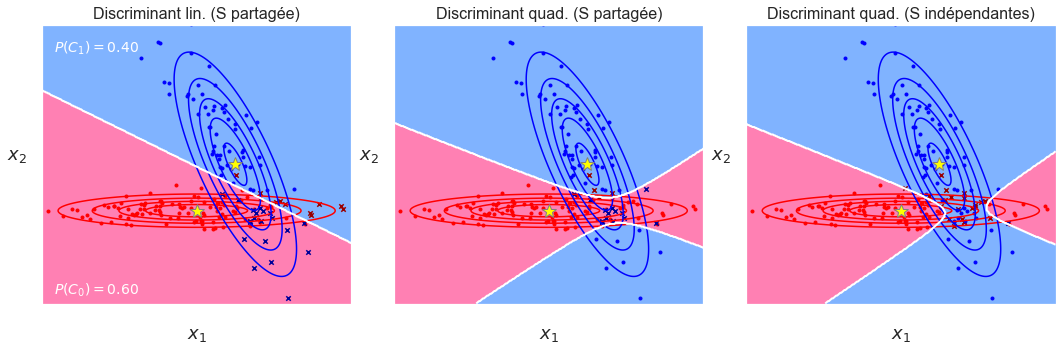

In [4]:

    # ------- Paramètres des gaussiennes --------

    mu = np.zeros((2,2))
    mu[0,:] = [0., -1.]
    mu[1,:] = [1., 0.]

    sigma = np.zeros((2,2))
    sigma[0,:] = [2, .2]
    sigma[1,:] = [1.5, .5]

    angle = np.array([0., -60]) 
    prob_C = np.array([0.6, 0.4]) 

    str0 = '$P(C_{0})=%.2f$' % (prob_C[0])
    str1 = '$P(C_{1})=%.2f$' % (prob_C[1])
    texte = [str0, str1]  
    
    texte_pos = np.zeros((2,2))
    texte_pos[0,:] = [-3.7, -2.7]
    texte_pos[1,:] = [-3.7, 2.5]
    
    x_min, x_max = -4., 4.
    y_min, y_max = -3., 3.
        
      
    # ----------- Génération des distributions avec MATRICES DE COVARIANCE INDIVIDUELLES --------------
    pdf = genere_distributions(mu, sigma, angle, prob_C, x_min, x_max, y_min, y_max)
    
    
    # -----------Affichage des distributions avec matrice de covariance partagée ---------
    # Commande pour déterminer, par essais et erreurs, les valeurs optimales des paramètres
    #pdf.affiche_PDF_avec_zones_influence(texte, texte_pos)
        
    # Commande pour sauvegarder les meilleurs résultats sans détails inutiles
    nom_figure = "Figure_26(2)_41.svg"
    pdf.affiche_PDF_avec_zones_influence(texte, texte_pos, affiche_tickmarks=False, nom_figure=nom_figure)
    

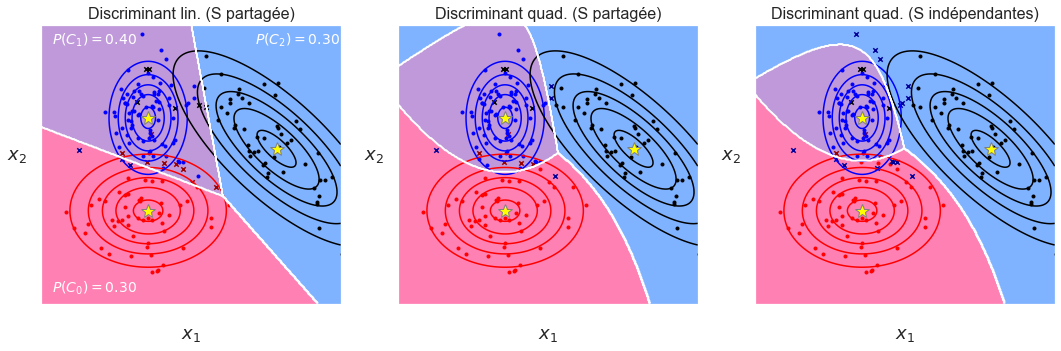

In [4]:

    # ------- Paramètres des gaussiennes --------
  
    mu = np.zeros((3,2))
    mu[0,:] = [0., 2.]
    mu[1,:] = [0., 5.]
    mu[2,:] = [6., 4.]

    sigma = np.zeros((3,2))
    sigma[0,:] = [2., 1.]
    sigma[1,:] = [1., 1.]
    sigma[2,:] = [1., 3.]

    angle = np.array([0., 0., 60]) 
    prob_C = np.array([0.3, 0.4, 0.3]) 

    str0 = '$P(C_{0})=%.2f$' % (prob_C[0])
    str1 = '$P(C_{1})=%.2f$' % (prob_C[1])
    str2 = '$P(C_{2})=%.2f$' % (prob_C[2])
    
    texte = [str0, str1, str2]
    texte_pos = np.zeros((3,2))
    texte_pos[0,:] = [-4.5, -.5]
    texte_pos[1,:] = [-4.5, 7.5]
    texte_pos[2,:] = [5., 7.5]    
    
    x_min, x_max = -5., 9.
    y_min, y_max = -1., 8.
        
        
    # ----------- Génération des distributions --------------
    pdf = genere_distributions(mu, sigma, angle, prob_C, x_min, x_max, y_min, y_max)
    
    
    # -----------Affichage des distributions avec matrice de covariance partagée ---------
    # Utiliser la commande suivante pour déterminer les valeurs optimales des paramètres 
    #pdf.affiche_PDF_avec_zones_influence(texte, texte_pos)
        
    # Affichage et sauvegarde des meilleurs résultats
    nom_figure = "Figure_27_41.svg"
    pdf.affiche_PDF_avec_zones_influence(texte, texte_pos, affiche_tickmarks=False, nom_figure=nom_figure)
    
    